In [2]:
library(igraph)
library(ggnetwork)
library(tidyverse)
library(magrittr)
library(cowplot)
library(tidygraph)

In [3]:
genesis <- read_tsv('../dmGWAS/Vegas2v2_CTnew.txt', col_types = 'icidiidddcd') %>%
    select(Gene, nSNPs, Pvalue, Top.0.1.pvalue, Best.SNP) %>%
    mutate(positive_genesis = ifelse(Pvalue < 0.05/n(), 'Yes', 'No'))

dmgwas <- read_tsv('../dmGWAS/module100.formatted.txt', 
                   col_names = FALSE, col_types = 'cc') %>%
    set_colnames(c('seed','module')) %>%
    # convert into long format
    mutate(gene = strsplit(module, ',')) %>% 
    unnest(gene) %>%
    select(-module)

ppi <- read_tsv('../../data/genesis/BIOGRID-ORGANISM-Homo_sapiens-3.4.160.tab.txt',
                col_types = 'cccccccciii') %>%
    select(OFFICIAL_SYMBOL_A, OFFICIAL_SYMBOL_B) %>%
    set_colnames(c('geneA','geneB')) %>%
    filter(geneA %in% dmgwas$gene & geneB %in% dmgwas$gene) %>%
    unique %>%
    graph_from_data_frame(directed = FALSE) %>%
    simplify

bcac <- read_tsv("../../data/bcac/icogs_bcac_public_results_euro.lite.txt", col_types = "cd") %>%
    rename(p_bcac = bcac_icogs1_risk_P1df)

# Gene overview

Warning message in fortify.network(intergraph::asNetwork(model), ...):
“duplicated edges detected”Warning message:
“Ignoring unknown parameters: segment.color”

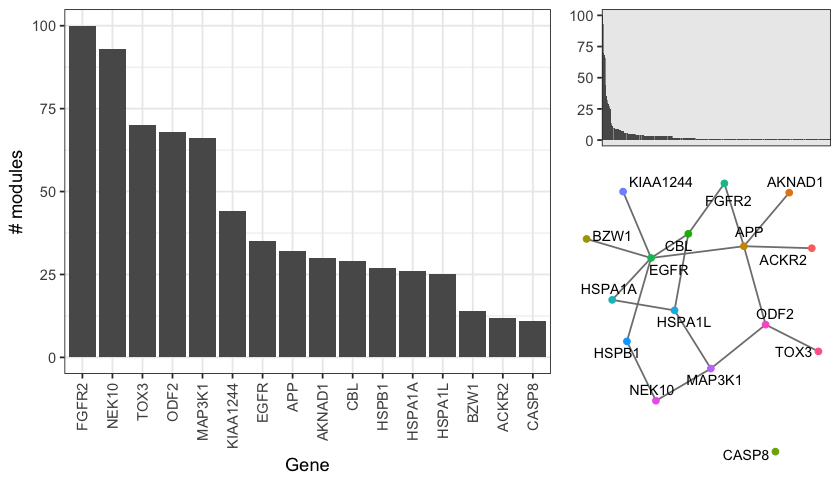

In [5]:
topGenes <- group_by(dmgwas, gene) %>% filter(n() > 10) %>% .$gene

all <- dmgwas %>%
    ggplot(aes(fct_infreq(gene))) +
        geom_bar() +
        theme_bw() +
        theme(axis.text.x = element_blank(), axis.ticks.x = element_blank(),
              axis.title.x = element_blank(), axis.title.y = element_blank())

top <- dmgwas %>%
    filter(gene %in% topGenes) %>%
    ggplot(aes(fct_infreq(gene))) +
        geom_bar() +
        theme_bw() +
        labs(x = 'Gene', y = '# modules') +
        theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5))

net_plot <- martini:::subnet(ppi, 'name', topGenes) %>%
    ggnetwork %>%
    ggplot(aes(x = x, y = y, xend = xend, yend = yend)) +
        geom_edges(color = "grey50") +
        geom_nodes(aes(color = vertex.names)) +
        geom_nodetext_repel(aes(label = vertex.names), size = 3) +
        theme_blank() +
        theme(legend.position = 'none')

options(repr.plot.width=7, repr.plot.height=4)
plot_grid(top, 
          plot_grid(all, net_plot, nrow = 2, rel_heights = c(1,2)), 
          rel_widths = c(2, 1))

Warning message in fortify.network(intergraph::asNetwork(model), ...):
“duplicated edges detected”Warning message:
“Ignoring unknown parameters: segment.color”

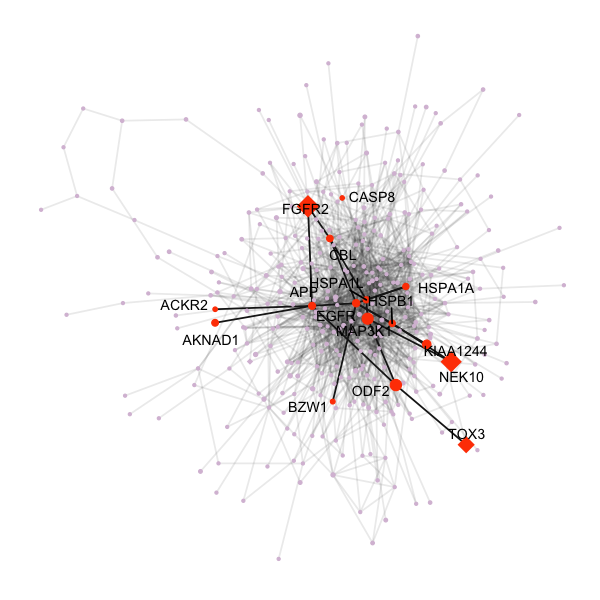

In [6]:
# recover SConES GM-selected SNPs
library(martini)
load("../../data/genesis/gi.net")

cols <- "ciiiccdli"
gm <- read_tsv("../genesis/cones.evo.chi2.consistency.additive.gm.tsv", col_types = cols)
gm_genes <- martini:::subvert(net, 'name', gm$snp[gm$selected] )$gene %>% unique %>% na.omit

# prepare final graph
submod <- martini:::subnet(ppi, 'name', dmgwas$gene) %>% simplify
sudmodInfo <- group_by(dmgwas, gene) %>% summarize( nSubmods = n() ) %>%
    filter(gene %in% V(submod)$name )
submod <- set_vertex_attr(submod, 'nSubmods', 
                          index = match(sudmodInfo$gene, V(submod)$name), 
                          sudmodInfo$nSubmods)

## create a core, with the genes frequently selected
core <- as_tbl_graph(submod, directed = FALSE) %>% 
    filter(name %in% topGenes) %>%
    activate(edges) %>%
    mutate(type = 'core')

## and a periphery, with the rest
periphery <- as_tbl_graph(submod - core, directed = FALSE) %>%
    activate(edges) %>%
    mutate(type = 'periphery')

solution <- graph_join(core, periphery, by = c("name", "nSubmods")) %>% 
    activate(nodes) %>%
    mutate(gene = ifelse(name %in% topGenes, name, ''),
           geneType = ifelse(name %in% topGenes, 'freq', 'rare'),
           scones = ifelse(name %in% gm_genes, 'scones', 'no')) %>%
    as.undirected(mode = 'each') %>%
    ggnetwork()
solution <- solution[order(solution$type, decreasing = T),]
solution <- solution[order(solution$geneType, decreasing = T),]

options(repr.plot.width = 5, repr.plot.height = 5)
solution %>%
    ggplot(aes(x = x, y = y, xend = xend, yend = yend)) +
        geom_edges(aes(alpha = type, color = type)) +
        geom_nodes(aes(color = geneType, size = nSubmods^2, shape = scones)) +
        geom_nodetext_repel(aes(label = gene), size = 3) +
        scale_alpha_manual(values = c('periphery' = 0.1, 'core' = 1)) +
        scale_color_manual(values = c('periphery' = 'gray20', 'core' = 'gray10',
                                      'rare' = 'thistle', 'freq' = 'orangered1')) +
        scale_shape_manual(values = c('scones' = 18, 'no' = 20)) +
        theme_blank() +
        theme(legend.position = 'none')

# Comparison to BCAC

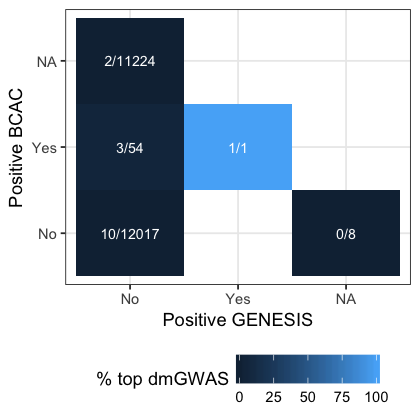

In [7]:
bcac <- read_delim('../../data/bcac/bcac.vegas.out.txt', delim = ' ', 
                   col_types = 'icidiidddcd') %>%
    select(Gene, nSNPs, Pvalue) %>%
    mutate(positive_bcac = ifelse(Pvalue < 0.05/n(), 'Yes', 'No'))

topGenes <- group_by(dmgwas, gene) %>% filter(n() > 10) %>% .$gene

options(repr.plot.width = 3.5, repr.plot.height = 3.5)
full_join(bcac, genesis, by = 'Gene') %>%
    mutate(selected = Gene %in% topGenes) %>%
    group_by(positive_bcac, positive_genesis) %>%
    summarize(label = paste(sum(selected), n(), sep = '/'),
              p = 100 * sum(selected)/n()) %>%
    ggplot(aes(positive_genesis, positive_bcac)) +
            geom_tile(aes(fill = p)) +
            geom_text(aes(label = label), size = 3, color = 'white') +
            labs(x = 'Positive GENESIS', y = 'Positive BCAC', fill = '% top dmGWAS') +
            theme_bw() +
            theme(legend.position = 'bottom')